In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import string

## 1. Load the dataset

In [ ]:
# load datasets given
df_movie_details = pd.read_json("../data/IMDB_movie_details.json", lines = True)
df_reviews = pd.read_json("../data/IMDB_reviews.json", lines = True)

In [ ]:
df_movie_details.info()

In [ ]:
df_reviews.info()

In [ ]:
df_reviews['is_spoiler'].value_counts()

In [ ]:
df_reviews = pd.read_pickle("../data/tokenized_reviews.pkl.gz", compression = 'gzip')

## 2. Text Preprocessing

### Tokenize review texts

In [ ]:
# TOKENIZING WILL TAKE ~15 MINUTES
# If you want to save after tokenizing feel free to do so to save time in tokenizing again
df_reviews['tokenized_summary'] = list(map(word_tokenize, df_reviews['review_summary']))
df_reviews['tokenized_reviews'] = list(map(word_tokenize, df_reviews['review_text']))

### Removing stop words and punctuations from the list

In [ ]:
# get stop words
stop_words_and_punctuations = set(stopwords.words('english') + list(string.punctuation))

In [ ]:
# remove stop words and punctuations from the tokenized list
df_reviews['tokenized_summary'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_reviews['tokenized_summary']))
df_reviews['tokenized_reviews'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_reviews['tokenized_reviews']))

### Stemming or Lemmatisation

In [ ]:
# stem or lemmatise words
stemmer = PorterStemmer()
df_reviews['tokenized_summary'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_reviews['tokenized_summary']))
df_reviews['tokenized_reviews'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_reviews['tokenized_reviews']))

### Return back the cleaned tokenized words into text

In [ ]:
df_reviews["text_tokenized"] = list(map(lambda x: ' '.join(x), df_reviews['tokenized_reviews']))

### Save the new dataset

In [ ]:
# save changes made to original dataset to save time tokenizing etc
df_reviews.to_pickle("../data/cleaned_reviews.pkl.gz", compression = 'gzip')

In [3]:
# to load dataset
df_reviews = pd.read_pickle("../data/cleaned_reviews.pkl.gz", compression = 'gzip')

### Undersample non-spoiler movies

In [4]:
df_movie_details["release_date"] = pd.to_datetime(df_movie_details["release_date"])

In [ ]:
(df_movie_details["release_date"] < "2015-01-01").value_counts()

In [5]:
train_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] < pd.Timestamp("2015-01-01")]
test_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] >= pd.Timestamp("2015-01-01")]

In [ ]:
df_reviews.groupby('movie_id')["is_spoiler"].value_counts()["tt0012349"]

In [58]:
df_train = df_reviews.loc[df_reviews["movie_id"].isin(train_movies)]
df_test = df_reviews.loc[df_reviews["movie_id"].isin(test_movies)]

In [59]:
df_train_spoiler = df_train.loc[df_reviews['is_spoiler'] == True]
df_train_non_spoiler = df_train.loc[df_reviews['is_spoiler'] == False]

df_train_non_spoiler = df_train_non_spoiler.sample(n = df_train_spoiler["is_spoiler"].count(), random_state = 42)
df_train = pd.concat([df_train_spoiler, df_train_non_spoiler])

df_test_spoiler = df_test.loc[df_reviews['is_spoiler'] == True]
df_test_non_spoiler = df_test.loc[df_reviews['is_spoiler'] == False]

df_test_non_spoiler = df_test_non_spoiler.sample(n = df_test_spoiler["is_spoiler"].count(), random_state = 42)
df_test = pd.concat([df_test_spoiler, df_test_non_spoiler])

In [60]:
df_test['is_spoiler'].value_counts()

True     20835
False    20835
Name: is_spoiler, dtype: int64

In [61]:
df_train['is_spoiler'].value_counts()

True     130089
False    130089
Name: is_spoiler, dtype: int64

## 3. Model Building

### Bag of words

In [ ]:
vectorizer = CountVectorizer()
bow_train = vectorizer.fit_transform(df_train["text_tokenized"])
bow_test = vectorizer.transform(df_test["review_text"])

In [ ]:
logistic_model = LogisticRegression(max_iter = 1e5)
logistic_model.fit(bow_train, df_train["is_spoiler"])

In [ ]:
logistic_model.score(bow_test, df_test["is_spoiler"])

In [ ]:
print(confusion_matrix(df_test["is_spoiler"], logistic_model.predict(bow_test)))

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(df_test["is_spoiler"], logistic_model.predict(bow_test))).plot()

In [ ]:
recall_score(df_test["is_spoiler"], logistic_model.predict(bow_test))
print(classification_report(df_test["is_spoiler"], logistic_model.predict(bow_test)))

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel = 'sigmoid', max_iter = 1e4)
clf.fit(bow_train, df_train["is_spoiler"])

In [ ]:
clf.score(bow_test, df_test["is_spoiler"])

In [ ]:
bow_train

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape = (bow_train.shape[1],), sparse = True),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
coo = bow_train.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
sparse_train = tf.SparseTensor(indices, coo.data, coo.shape)

coo = bow_test.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
sparse_test = tf.SparseTensor(indices, coo.data, coo.shape)

In [ ]:
model.fit(sparse_train, df_train["is_spoiler"].to_numpy(), validation_data = (sparse_test, df_test["is_spoiler"].to_numpy()), epochs = 2)

In [ ]:
loss, accuracy = model.evaluate(sparse_train, df_train["is_spoiler"].to_numpy(), verbose = False)
accuracy

In [ ]:
model.evaluate(sparse_test, df_test["is_spoiler"].to_numpy(), verbose = False)

In [ ]:
y_pred = model.predict(sparse_test, verbose = False) > 0.5
y_pred = y_pred.astype('int')

In [ ]:
print(classification_report(df_test["is_spoiler"], y_pred))

In [ ]:
print(confusion_matrix(df_test["is_spoiler"], y_pred))

### Tf-idf

In [62]:
tfidfvectorizer = TfidfVectorizer()
tfidf_train = tfidfvectorizer.fit_transform(df_train['text_tokenized'])
tfidf_test = tfidfvectorizer.transform(df_test['text_tokenized'])

In [93]:
logistic_model = LogisticRegression(max_iter = 1e5, class_weight={0: 0.47, 1: 0.53})
logistic_model.fit(tfidf_train, df_train["is_spoiler"])

LogisticRegression(class_weight={0: 0.47, 1: 0.53}, max_iter=100000.0)

In [94]:
logistic_model.score(tfidf_test, df_test["is_spoiler"])

0.6683705303575714

In [91]:
logistic_model.score(tfidf_test, df_test["is_spoiler"])

0.6699304055675546

In [95]:
print(confusion_matrix(df_test["is_spoiler"], logistic_model.predict(tfidf_test)))

[[13033  7802]
 [ 6017 14818]]


In [92]:
print(confusion_matrix(df_test["is_spoiler"], logistic_model.predict(tfidf_test)))

[[14012  6823]
 [ 6931 13904]]


In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='sigmoid', max_iter = 1e5)
clf.fit(tfidf_train, df_train['is_spoiler'])

In [ ]:
clf.score(tfidf_test, df_test['is_spoiler'])

In [49]:
tfidf_train

<260178x200207 sparse matrix of type '<class 'numpy.float64'>'
	with 30675097 stored elements in Compressed Sparse Row format>

In [63]:
tfidf_coo_train = tfidf_train.tocoo()
indices = np.mat([tfidf_coo_train.row, tfidf_coo_train.col]).transpose()
tfidf_sparse_train = tf.sparse.reorder(tf.SparseTensor(indices, tfidf_coo_train.data, tfidf_coo_train.shape))

tfidf_coo_test = tfidf_test.tocoo()
indices = np.mat([tfidf_coo_test.row, tfidf_coo_test.col]).transpose()
tfidf_sparse_test = tf.sparse.reorder(tf.SparseTensor(indices, tfidf_coo_test.data, tfidf_coo_test.shape))

In [64]:
tfidf_model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape = (tfidf_train.shape[1],), sparse = True),
                                          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(1e-3)),
                                          tf.keras.layers.Dropout(0.1),
                                          tf.keras.layers.Dense(1, activation='sigmoid')])

In [65]:
tfidf_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
             optimizer='adam',
             metrics=['accuracy'])

In [66]:
tfidf_model.fit(tfidf_sparse_train, df_train["is_spoiler"].to_numpy(), validation_data = (tfidf_sparse_test, df_test["is_spoiler"].to_numpy()), epochs = 5)

Epoch 1/5
8131/8131 [==============================] - 2393s 294ms/step - loss: 0.7756 - accuracy: 0.6663 - val_loss: 0.7925 - val_accuracy: 0.6440
Epoch 2/5
8131/8131 [==============================] - 2396s 295ms/step - loss: 0.7587 - accuracy: 0.6749 - val_loss: 0.7756 - val_accuracy: 0.6568
Epoch 3/5
8131/8131 [==============================] - 2416s 297ms/step - loss: 0.7383 - accuracy: 0.6784 - val_loss: 0.7525 - val_accuracy: 0.6520
Epoch 4/5
 171/8131 [..............................] - ETA: 37:17 - loss: 0.7228 - accuracy: 0.6837

KeyboardInterrupt: 

In [67]:
print(classification_report(df_test['is_spoiler'], tfidf_model.predict(tfidf_sparse_test) > 0.5))

1303/1303 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

       False       0.64      0.71      0.67     20835
        True       0.67      0.60      0.63     20835

    accuracy                           0.65     41670
   macro avg       0.66      0.65      0.65     41670
weighted avg       0.66      0.65      0.65     41670



In [74]:
print(confusion_matrix(df_test['is_spoiler'], tfidf_model.predict(tfidf_sparse_test) > 0.5))

1303/1303 [==============================] - 3s 2ms/step
[[14797  6038]
 [ 8408 12427]]


1303/1303 [==============================] - 3s 3ms/step


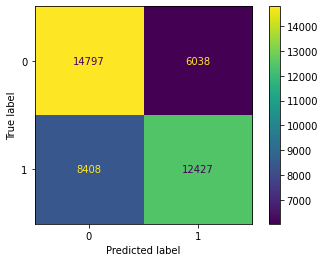

In [69]:
ConfusionMatrixDisplay(confusion_matrix(df_test['is_spoiler'], tfidf_model.predict(tfidf_sparse_test) > 0.5)).plot()

### Word Embedding

In [10]:
from gensim.models import Word2Vec

In [12]:
embedding_model = Word2Vec(df_train['tokenized_reviews'], min_count = 1)

In [32]:
embedding_train = []
for i in df_train.index:
    embedding_train.append(embedding_model.wv[df_train.loc[i, 'tokenized_reviews']])

In [36]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(1e-3)),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(1e-3)),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])